In [21]:
import os
from os import listdir
import pickle
import numpy as np
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [22]:
model = VGG16()

model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
print (model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [23]:
BASE_DIR = '../input/flickr8k'
# os.listdir(BASE_DIR)
directory = BASE_DIR + '/' + 'Images'
# os.listdir(directory)

In [24]:
features = {}
i=0
for name in (os.listdir(directory)):
    img_path = directory + '/' + name
    
    image = load_img(img_path , target_size = (224 , 224))
    
    image = img_to_array(image)
    
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    
    image = preprocess_input(image)
    
    feature = model.predict(image , verbose = 0)
    
    img_id = name.split('.')[0] 
    
    features[img_id] = feature
    if(i%1000 == 0): 
        print(i)
    i = i+1
        

0
1000
2000
3000
4000
5000
6000
7000
8000


In [25]:
print(len(features))

8091


In [33]:
with open(os.path.join(BASE_DIR , 'captions.txt') , 'r') as f:
    next(f)
    
    cap = f.read()
    

In [35]:
from tqdm import tqdm

mapp = {}
for lines in tqdm(cap.split('\n')):
    data = lines.split(',')
    if len(lines) < 2:
        continue
    img_id, caption = data[0] , data[1:]
    
    img_id = img_id.split('.')[0]
    
    caption = " ".join(caption)
     
    if img_id not in mapp:
        mapp[img_id] = []
    mapp[img_id].append(caption)
    
    



  0%|          | 0/40456 [00:00<?, ?it/s]

100%|██████████| 40456/40456 [00:00<00:00, 317954.64it/s]


In [36]:
def preprocess(mapp):
    for key, captions in mapp.items():
        for i in range(len(captions)):
            capt = captions[i]
            capt = capt.lower()
            capt = capt.replace('[^A-Za-z]' , '')
            capt = capt.replace('\s+' , ' ')
            capt = 'startse ' + " ".join([word for word in capt.split() if len(word) > 1]) + ' endse'
            
            captions[i] = capt

In [37]:
preprocess(mapp)

In [38]:
mapp['1000268201_693b08cb0e']
# len(mapp)

['startse child in pink dress is climbing up set of stairs in an entry way endse',
 'startse girl going into wooden building endse',
 'startse little girl climbing into wooden playhouse endse',
 'startse little girl climbing the stairs to her playhouse endse',
 'startse little girl in pink dress going into wooden cabin endse']

In [39]:
all_capt = []

for key in mapp:
    for captions in mapp[key]:
        all_capt.append(captions)

In [40]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_capt)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(capt.split()) for capt in all_capt)

In [41]:
image_ids = list(mapp.keys())
split = int(len(image_ids)*0.8)
train = image_ids[:split]
test = image_ids[split: ]

In [42]:
from keras.utils import to_categorical
def gen(keys , mapp , features , max_length , vocab_size , batch_size,tokenizer):
    X1, X2, y = list(), list() , list()
    n=0
    
    while 1:
        for k in keys:
            n+=1
            captions = mapp[k]
            for cap in captions:
                seq = tokenizer.texts_to_sequences([cap])[0]
                for i in range(1, len(seq)):
                    in_seq , out_seq = seq[:i] , seq[i]
                    in_seq = pad_sequences([in_seq] , maxlen = max_length)[0]
                    out_seq = to_categorical([out_seq] , num_classes = vocab_size)[0]
                    
                    X1.append(features[k][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1,X2,y = np.array(X1) , np.array(X2) , np.array(y)
                yield [X1 , X2] , y
                X1, X2, y = list(), list() , list()
                n=0

In [44]:
inp1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inp1)
fe2 = Dense(256 , activation = 'relu')(fe1)

inp2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size , 256 , mask_zero = True)(inp2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

d1 = add([fe2 , se3])
d2 = Dense(256 , activation = 'relu')(d1)
outputs = Dense(vocab_size , activation = 'softmax')(d2)

model = Model(inputs = [inp1 , inp2] , outputs = outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')


# plot_model(model , show_shapes = True)



In [45]:
epochs = 18
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    generator = gen(train, mapp, features, max_length, vocab_size, batch_size, tokenizer)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

    

202/202 [==============================] - 113s 560ms/step - loss: 2.2323


In [46]:
import pickle
Pkl_Filename = "caption.pkl" 
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model, file)

In [ ]:
# os.listdir('/kaggle/working')

In [47]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [54]:

def predict_caption(model, image, tokenizer, max_length):
    
    in_text = 'startse '
    
    for i in range(max_length):
        
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        
        sequence = pad_sequences([sequence], max_length)
        
        yhat = model.predict([image, sequence], verbose=0)
        
        yhat = np.argmax(yhat)
        
        word = idx_to_word(yhat, tokenizer)
        
        if word is None:
            break
        
        in_text += " " + word
        
        if word == 'endse':
            break
      
    return in_text

In [55]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    
    
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startse man in hat is displaying pictures next to skier in blue hat endse
startse man skis past another man displaying paintings in the snow endse
startse person wearing skis looking at framed pictures set up in the snow endse
startse skier looks at framed pictures in the snow next to trees endse
startse man on skis looking at artwork for sale in the snow endse
--------------------Predicted--------------------
startse  two people are displaying pictures with framed pictures in the snow endse


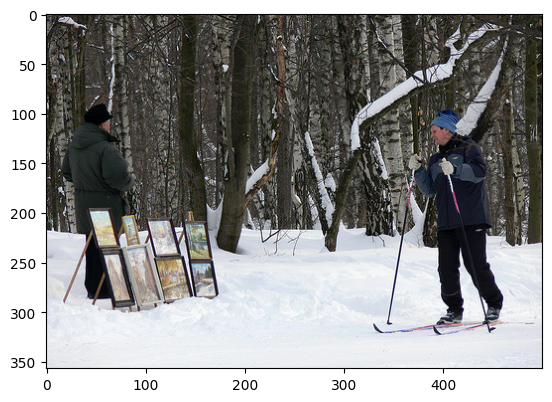

In [57]:
generate_caption("101669240_b2d3e7f17b.jpg")